Flight delay is a costly problem to consumers, airlines, and industrial experts. Delays provoke complaints from passengers, create high costs to airlines, and result in difficulties for airport operations. It is therefore important for the Federal Aviation Administration (FAA) to understand the causes of delay as a means to reduce the total cost that delays can cause.

Known factors that cause flight delays include weather at the origin airport, congestion at the origin airport, and air traffic management (ATM) decisions such as Ground Delay Programs (GDP). Each component interacts with other components in complex ways, which is why flight delays are an inherently stochastic phenomenon. Simply examining the marginal distributions of such factor does not truly reveal the effects that such factors have or the relationship between any two of such factors.

Here, we will perform a case study of the use of Bayesian networks to model the relationship between different components of aircraft delay and the causal factors that affect delays. Bayesian networks allow us to simultaneously examine multiple components of delay and their relationships in a single analysis, an advantage that the use of Bayesian networks has over linear and nonlinear regression models. Moreover, Bayesian network models provide not only just predictions of future delays that incorporate the interrelationships among causal factors, but also a means of assessing the ultimate influence each causal factors has on arrival delay.

In particular, we will examine delays in flight from San Francisco International Airport (SFO) to Philadelphia International Airport (PHL).

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import time
import calendar
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
def filterRoutes(df):
    '''
    filter df to contain delayed fligths from SFO to PHL routes only.
    '''
    df = df[(df['ORIGIN'] == 'SFO') & (df['DEST'] == 'PHL') & (df['ARR_DELAY'] > 0)]
    df = df.reset_index()
    return df.drop(['index','YEAR','ORIGIN','DEST', 'UNIQUE_CARRIER','DEP_TIME','DEP_TIME_BLK','DEP_DELAY_GROUP', 'DEP_DELAY_NEW', \
                    'DEP_DEL15','WHEELS_OFF','WHEELS_ON','ARR_DELAY','ARR_DELAY_NEW','Unnamed: 29'],axis=1)

def dateColumns(df):
    dates = [str(d).replace('/','') for d in list(df['Date'])]
    dates = [time.strptime(d,'%m%d%Y') for d in dates]
    df['MONTH'] = [d.tm_mon for d in dates]
    df['DAY'] = [d.tm_mday for d in dates]

# The Nitty-Gritty: Preparing the Data

## Read and Merge

We are working with two datasets. The first is provided by the Bureau of Transportation Statistics and contains flight information, including Common Reporting Standard (CRS) arrival and departure times, causes of delay, and time spend taxiing in and out. We will start by reading in twelve months' worth of data and filtering for just the SFO to PHL routes.

In [3]:
# read data and filter for relevant delayed flights
jan_df = filterRoutes(pd.read_csv('./month/jan2017.csv'))
feb_df = filterRoutes(pd.read_csv('./month/feb2017.csv'))
mar_df = filterRoutes(pd.read_csv('./month/mar2017.csv'))
apr_df = filterRoutes(pd.read_csv('./month/apr2017.csv'))
may_df = filterRoutes(pd.read_csv('./month/may2017.csv'))
jun_df = filterRoutes(pd.read_csv('./month/jun2017.csv'))
jul_df = filterRoutes(pd.read_csv('./month/jul2017.csv'))
aug_df = filterRoutes(pd.read_csv('./month/aug2017.csv'))
sep_df = filterRoutes(pd.read_csv('./month/sep2017.csv'))
oct_df = filterRoutes(pd.read_csv('./month/oct2017.csv'))
nov_df = filterRoutes(pd.read_csv('./month/nov2017.csv'))
dec_df = filterRoutes(pd.read_csv('./month/dec2017.csv'))

# concatenate dataframes by quarter
flights_df = pd.concat([jan_df, feb_df,mar_df,apr_df, may_df, jun_df, jul_df, aug_df, sep_df, oct_df, nov_df, dec_df])

# keep hour information from CRS but not minutes
flights_df['CRS_DEP_TIME'] = flights_df['CRS_DEP_TIME'] // 100
flights_df['CRS_ARR_TIME'] = flights_df['CRS_ARR_TIME'] // 100

Secondly, we will read in the data provided by the Federal Aviation Administration (FAA) on airport situations in SFO and PHL in 2017 in 'ASPM : Airport Analysis : Delayed Flights Report.' After reading in the data, we will merge the two dataframes to create one flights_df dataframe.

In [4]:
airports_df = pd.read_csv('./faa-aspm/airports.csv').dropna(axis=0,how='all')

# split Date into MONTH and DAY
airports_df['Facility'] = airports_df['Facility'].str.strip()
dateColumns(airports_df)
airports_df = airports_df.drop(['Date','% DelayedGateDepartures','% DelayedGateArrivals','Date'],axis=1)
airports_df = airports_df.drop(['DeparturesFor MetricComputation','ArrivalsFor MetricComputation','AverageMinutesOf DelayPer DelayedGateDeparture','AverageMinutesOf DelayPer DelayedGateArrival'],axis=1)

# find departure and arrival informations at airport at time of departure/arrival
# SFO (departure)
flights_SFO_df = pd.merge(flights_df, airports_df, how='inner', left_on=['MONTH','DAY_OF_MONTH','CRS_DEP_TIME'],\
                         right_on=['MONTH','DAY','Hour'])
flights_SFO_df = flights_SFO_df[flights_SFO_df['Facility'] == 'SFO']
# PHL (arrival)
flights_PHL_df = pd.merge(flights_df, airports_df, how='inner', left_on=['MONTH','DAY_OF_MONTH','CRS_DEP_TIME'],\
                         right_on=['MONTH','DAY','Hour'])
flights_PHL_df = flights_PHL_df[flights_PHL_df['Facility'] == 'PHL']
# set departure/arrival information as fields of flights_df
flights_df['DelayedDepartureSFO'] = flights_PHL_df['DelayedGateDepartures']
flights_df['ScheduledDepartureSFO'] = flights_PHL_df['ScheduledDepartures']
flights_df['DelayedArrivalPHL'] = flights_PHL_df['DelayedGateArrivals']
flights_df['ScheduledArrivalPHL'] = flights_PHL_df['ScheduledArrivals']
flights_df.fillna(0,inplace=True)
flights_df = flights_df.reset_index()
flights_df = flights_df.drop(['index'],axis=1)

We no longer need information about DAY_OF_MONTH, so we will drop that column. The compiled data is as below. Due to the length of each field name, we transpose the dataframe for readability.

In [5]:
flights_df = flights_df.drop(['DAY_OF_MONTH'],axis=1)
flights_df.transpose()

,0,1,2,3,4,5,6,7,8,9,...,958,959,960,961,962,963,964,965,966,967
QUARTER,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
MONTH,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0
DAY_OF_WEEK,3.0,6.0,4.0,6.0,7.0,1.0,2.0,4.0,5.0,4.0,...,4.0,4.0,3.0,2.0,1.0,2.0,1.0,7.0,5.0,4.0
CRS_DEP_TIME,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,...,15.0,8.0,8.0,8.0,8.0,8.0,22.0,22.0,8.0,22.0
DEP_DELAY,28.0,90.0,32.0,24.0,-1.0,0.0,-9.0,17.0,2.0,1.0,...,81.0,23.0,-1.0,-6.0,14.0,10.0,-5.0,0.0,35.0,0.0
TAXI_OUT,26.0,12.0,17.0,16.0,29.0,16.0,19.0,24.0,23.0,31.0,...,20.0,29.0,39.0,36.0,45.0,21.0,29.0,27.0,29.0,27.0
TAXI_IN,3.0,5.0,4.0,6.0,4.0,6.0,5.0,3.0,3.0,7.0,...,5.0,6.0,5.0,5.0,8.0,11.0,11.0,7.0,10.0,5.0
CRS_ARR_TIME,6.0,6.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,...,0.0,17.0,16.0,16.0,16.0,16.0,7.0,7.0,16.0,7.0
ARR_DEL15,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
DIVERTED,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Train and Test Data

Let the five delay causes (CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY) and the variable we are looking to explain (ARR_DEL15) be nodes. We must perform regression analysis to determine dependency relationships.

In [6]:
# 20% test data
from sklearn.model_selection import train_test_split
# 774 train data, 194 test data
train_df,test_df = train_test_split(flights_df, test_size=0.2)

# Finding Dependencies: Regression Analysis

We use the Ordinary Least Squares (OLS) method to find dependencies, starting with what we know to be the final outcome: ARR_DEL15 (which is 0 if the flight does not arrive more than 15 minutes late, 1 otherwise).

### ARR_DEL15

In [7]:
arr_15_from = ['CRS_DEP_TIME','DEP_DELAY','CRS_ARR_TIME','CARRIER_DELAY','NAS_DELAY','LATE_AIRCRAFT_DELAY']
X = train_df[arr_15_from]
y = train_df['ARR_DEL15']

model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              ARR_DEL15   R-squared:                       0.714
Model:                            OLS   Adj. R-squared:                  0.712
Method:                 Least Squares   F-statistic:                     320.1
Date:                Thu, 29 Mar 2018   Prob (F-statistic):          4.23e-205
Time:                        02:14:15   Log-Likelihood:                -379.54
No. Observations:                 774   AIC:                             771.1
Df Residuals:                     768   BIC:                             799.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
CRS_DEP_TIME            0.0156      0.001     11.514      0.000       0.013       0.018
DEP_DELAY              -0.0030      0.001     -3.520      0.000      -0.005      -0.001
CRS_ARR_TIME            0.0105      0.001      7.068      0.000       0.008       0.013
CARRIER_DELAY           0.0058      0.001      6.039      0.000       0.004       0.008
NAS_DELAY               0.0126      0.001     15.428      0.000       0.011       0.014
LATE_AIRCRAFT_DELAY     0.0109      0.001      9.178      0.000       0.009       0.013
==============================================================================
Omnibus:                       10.829   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               11.039
Skew:                          -0.258   Prob(JB):                      0.00401
Kurtosis:                       3.275   Cond. No.                         8.24
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [8]:
flights_edges_dict = dict()
for node in arr_15_from:
    flights_edges_dict[node] = 'ARR_DEL15'
flight_edges_df = pd.DataFrame(list(flights_edges_dict.items()), columns=['from_node', 'to_node'])

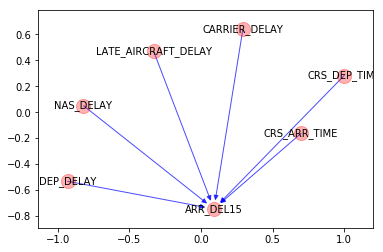

In [9]:
bn = nx.from_pandas_edgelist(flight_edges_df,source='from_node',target='to_node',create_using=nx.DiGraph())
# draw graph
bn_edges = [edge for edge in bn.edges()]
pos = nx.spring_layout(bn)
nx.draw_networkx_nodes(bn, pos, cmap=plt.get_cmap('jet'), node_size = 200,alpha=0.3)
nx.draw_networkx_labels(bn, pos,font_size='10')
nx.draw_networkx_edges(bn, pos, edgelist=bn_edges, edge_color='b',style='dot', arrows=True,arrow_size = 15,alpha=0.7)
plt.show()

### NAS Delay

Carrier Delay depends on

In [10]:
nas_delay_from = ['QUARTER','CRS_DEP_TIME','DEP_DELAY','TAXI_OUT','TAXI_IN','CRS_ARR_TIME','DIVERTED',\
              'CARRIER_DELAY','WEATHER_DELAY','SECURITY_DELAY','LATE_AIRCRAFT_DELAY',]

X = train_df[nas_delay_from]
y = train_df['NAS_DELAY']

model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              NAS_DELAY   R-squared:                       0.627
Model:                            OLS   Adj. R-squared:                  0.623
Method:                 Least Squares   F-statistic:                     128.7
Date:                Thu, 29 Mar 2018   Prob (F-statistic):          2.23e-156
Time:                        02:14:15   Log-Likelihood:                -3087.1
No. Observations:                 774   AIC:                             6194.
Df Residuals:                     764   BIC:                             6241.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
QUARTER                -2.0874      0.427     -4.885      0.000      -2.926      -1.248
CRS_DEP_TIME           -0.6127      0.069     -8.943      0.000      -0.747      -0.478
DEP_DELAY               0.6642      0.028     23.551      0.000       0.609       0.720
TAXI_OUT                0.8129      0.045     18.141      0.000       0.725       0.901
TAXI_IN                 0.8539      0.054     15.708      0.000       0.747       0.961
CRS_ARR_TIME           -0.6897      0.078     -8.893      0.000      -0.842      -0.537
DIVERTED            -7.952e-16   3.23e-16     -2.461      0.014   -1.43e-15   -1.61e-16
CARRIER_DELAY          -0.6749      0.031    -21.644      0.000      -0.736      -0.614
WEATHER_DELAY          -0.6121      0.083     -7.380      0.000      -0.775      -0.449
SECURITY_DELAY         -0.6136      0.232     -2.640      0.008      -1.070      -0.157
LATE_AIRCRAFT_DELAY    -0.7286      0.038    -19.280      0.000      -0.803      -0.654
==============================================================================
Omnibus:                      159.231   Durbin-Watson:                   2.032
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              397.362
Skew:                           1.068   Prob(JB):                     5.18e-87
Kurtosis:                       5.785   Cond. No.                     9.16e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.99e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [11]:
flights_edges_dict = dict()
for node in nas_delay_from:
    flights_edges_dict[node] = 'NAS_DELAY'
temp_df = pd.DataFrame(list(flights_edges_dict.items()), columns=['from_node', 'to_node'])
flight_edges_df = pd.concat([flight_edges_df, temp_df]).reset_index()
flight_edges_df = flight_edges_df.drop(['index'], axis=1)

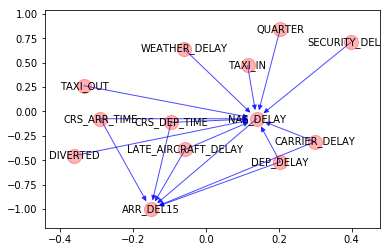

In [12]:
bn = nx.from_pandas_edgelist(flight_edges_df,source='from_node',target='to_node',create_using=nx.DiGraph())
# draw graph
bn_edges = [edge for edge in bn.edges()]
pos = nx.spring_layout(bn)
nx.draw_networkx_nodes(bn, pos, cmap=plt.get_cmap('jet'), node_size = 200,alpha=0.3)
nx.draw_networkx_labels(bn, pos,font_size='10')
nx.draw_networkx_edges(bn, pos, edgelist=bn_edges, edge_color='b',style='dot', arrows=True,arrow_size = 15,alpha=0.7)
plt.show()

## Late Aircraft Delay

OLS with dependent variable WEATHER_DELAY and independent variable DAY_OF_WEEK leads to R-squared value of 0.000.
,
 'ScheduledArrivalPHL' definitely not part of it.

In [13]:
late_aircraft_from = ['MONTH','DEP_DELAY','CARRIER_DELAY','WEATHER_DELAY','NAS_DELAY']
X = train_df[late_aircraft_from]
y = train_df['LATE_AIRCRAFT_DELAY']

model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     LATE_AIRCRAFT_DELAY   R-squared:                       0.776
Model:                             OLS   Adj. R-squared:                  0.774
Method:                  Least Squares   F-statistic:                     532.1
Date:                 Thu, 29 Mar 2018   Prob (F-statistic):          8.75e-247
Time:                         02:14:15   Log-Likelihood:                -2982.5
No. Observations:                  774   AIC:                             5975.
Df Residuals:                      769   BIC:                             5998.
Df Model:                            5                                         
Covariance Type:             nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
MONTH             0.3210      0.060      5.382      0.000       0.204       0.438
DEP_DELAY         0.6443      0.013     48.076      0.000       0.618       0.671
CARRIER_DELAY    -0.6518      0.018    -35.790      0.000      -0.688      -0.616
WEATHER_DELAY    -0.6546      0.069     -9.441      0.000      -0.791      -0.518
NAS_DELAY        -0.2786      0.022    -12.940      0.000      -0.321      -0.236
==============================================================================
Omnibus:                      235.777   Durbin-Watson:                   2.033
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8034.976
Skew:                          -0.678   Prob(JB):                         0.00
Kurtosis:                      18.726   Cond. No.                         10.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [14]:
flights_edges_dict = dict()
for node in late_aircraft_from:
    flights_edges_dict[node] = 'LATE_AIRCRAFT_DELAY'
temp_df = pd.DataFrame(list(flights_edges_dict.items()), columns=['from_node', 'to_node'])
flight_edges_df = pd.concat([flight_edges_df, temp_df]).reset_index()
flight_edges_df = flight_edges_df.drop(['index'], axis=1)

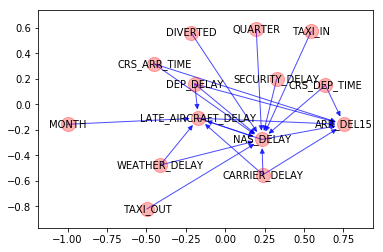

In [15]:
bn = nx.from_pandas_edgelist(flight_edges_df,source='from_node',target='to_node',create_using=nx.DiGraph())
# draw graph
bn_edges = [edge for edge in bn.edges()]
pos = nx.spring_layout(bn)
nx.draw_networkx_nodes(bn, pos, cmap=plt.get_cmap('jet'), node_size = 200,alpha=0.3)
nx.draw_networkx_labels(bn, pos,font_size='10')
nx.draw_networkx_edges(bn, pos, edgelist=bn_edges, edge_color='b',style='dot', arrows=True,arrow_size = 15,alpha=0.7)
plt.show()

In [16]:
[
'QUARTER',
 'MONTH',
 'DAY_OF_WEEK',
 'CRS_DEP_TIME',
 'DEP_DELAY',
 'TAXI_OUT',
 'TAXI_IN',
 'CRS_ARR_TIME',
 'ARR_DEL15',
 'DIVERTED',
 'CARRIER_DELAY',
 'WEATHER_DELAY',
 'NAS_DELAY',
 'SECURITY_DELAY',
 'LATE_AIRCRAFT_DELAY',
 'DelayedDepartureSFO',
 'ScheduledDepartureSFO',
 'DelayedArrivalPHL',
 'ScheduledArrivalPHL'
]

['QUARTER',
 'MONTH',
 'DAY_OF_WEEK',
 'CRS_DEP_TIME',
 'DEP_DELAY',
 'TAXI_OUT',
 'TAXI_IN',
 'CRS_ARR_TIME',
 'ARR_DEL15',
 'DIVERTED',
 'CARRIER_DELAY',
 'WEATHER_DELAY',
 'NAS_DELAY',
 'SECURITY_DELAY',
 'LATE_AIRCRAFT_DELAY',
 'DelayedDepartureSFO',
 'ScheduledDepartureSFO',
 'DelayedArrivalPHL',
 'ScheduledArrivalPHL']

In [17]:
flights_edges_dict = dict()
for node in nas_delay_from:
    flights_edges_dict[node] = 'NAS_DELAY'
temp_df = pd.DataFrame(list(flights_edges_dict.items()), columns=['from_node', 'to_node'])
flight_edges_df = pd.concat([flight_edges_df, temp_df]).reset_index()
flight_edges_df = flight_edges_df.drop(['index'], axis=1)

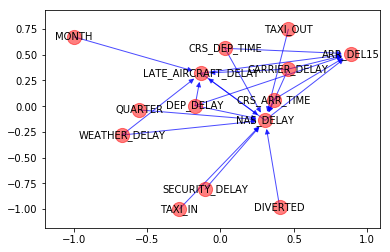

In [18]:
bn = nx.from_pandas_edgelist(flight_edges_df,source='from_node',target='to_node',create_using=nx.DiGraph())
# draw graph
bn_edges = [edge for edge in bn.edges()]
pos = nx.spring_layout(bn)
nx.draw_networkx_nodes(bn, pos, cmap=plt.get_cmap('jet'), node_size = 200,alpha=0.5)
nx.draw_networkx_labels(bn, pos,font_size='10')
nx.draw_networkx_edges(bn, pos, edgelist=bn_edges, edge_color='b',style='dot', arrows=True,arrow_size = 15,alpha=0.7)
# nx.draw_networkx_edges(bn, pos, edgelist=black_edges, arrows=False)
plt.show()